In [3]:
%matplotlib inline
import pandas as pd
from gqlalchemy import Memgraph
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pickle

import networkx as nx
import tnetwork as tn
import tnetwork.DCD.externals
from sklearn.preprocessing import OneHotEncoder

from scipy.sparse import csr_matrix, vstack, hstack
from scipy.sparse.linalg import norm
import scipy

import Levenshtein as levenshtein

from pymongo import MongoClient
from networkx.algorithms.similarity import optimize_graph_edit_distance as oged
from networkx.algorithms.community import louvain_partitions, louvain_communities

In [8]:
# with open(f"last_step_no_network.pickle", mode="rb") as file:
#     G = pickle.load(file)
# Make a connection to the database


def get_mongo_db(simulation):
    client = MongoClient("mongodb://localhost:27017")
    db = client[simulation]
    return db


def get_timestep(timestep, simulation):
    db = get_mongo_db(simulation)["level_0_edges"]
    cursor = db.find({"step": timestep}, {"_id": 0, "from_id": 1, "to_id": 1, "weight": 1})
    edges = pd.DataFrame(list(cursor))
    G = nx.from_pandas_edgelist(edges, source="from_id", target="to_id", edge_attr="weight", create_using=nx.Graph)
    for i in range(50000):
        if i not in G.nodes():
            G.add_node(i)
    return G

In [9]:
client = MongoClient("mongodb://localhost:27017")
collection = client["brain"]["hierarchy"]
cursor = collection.find({}, {"_id": 0, "neuron_id": 1, "community_level4": 1})
hierarchy = pd.DataFrame(list(cursor)).drop_duplicates().reset_index(drop=True)
print(hierarchy)
coms = hierarchy["community_level4"]

       community_level4  neuron_id
0                     0          0
1                     0          1
2                     0          2
3                     0          3
4                     0          4
...                 ...        ...
49995                 8      49995
49996                 8      49996
49997                 8      49997
49998                 8      49998
49999                 8      49999

[50000 rows x 2 columns]


In [6]:
# partition = [set() for i in range(5000)]
# for i in G.nodes():
#     partition[i // 10].add(i)

In [10]:
def flip_partitioning(partitioning):
    nodes = [item for sublist in partitioning.values() for item in sublist]
    return dict(zip(nodes, map(lambda x: next(int(k) for k in partitioning.keys() if x in partitioning[k]), nodes)))

def unflip_partitioning(partitioning):
    return {i: [k for k, v in partitioning.items() if v == i] for i in set(partitioning.values())}

coms_dict = dict(zip(range(len(coms)), coms))
partition = unflip_partitioning(coms_dict)

In [12]:
simulations = ["calcium", "no_network",] # "disable", "stimulus"]

mods = {simulation: [] for simulation in simulations}

for simulation in simulations:
    print(simulation)
    start = 0 if simulation != "no_network" else 4
    for t in tqdm(range(start, 101)):
        G = get_timestep(t * 10000, simulation)
        mod = nx.algorithms.community.modularity(G, partition.values())
        mods[simulation].append(mod)
    if simulation == "no_network":
        mods[simulation] = [0,0,0,0] + mods[simulation]


calcium


100%|██████████| 101/101 [19:23<00:00, 11.52s/it]


no_network


100%|██████████| 97/97 [19:14<00:00, 11.90s/it]


In [22]:
no_network_mods = [0,0,0,0] + mods

In [13]:
df = pd.DataFrame({"no_network": mods["no_network"], "calcium": mods["calcium"]})

In [16]:
df.to_csv("modularities.csv")

     no_network   calcium
0      0.000000  0.671210
1      0.000000  0.671210
2      0.000000  0.671210
3      0.000000  0.671210
4      0.668492  0.671210
..          ...       ...
96     0.670924  0.629557
97     0.670986  0.629365
98     0.671011  0.628952
99     0.671124  0.628333
100    0.671208  0.628004

[101 rows x 2 columns]


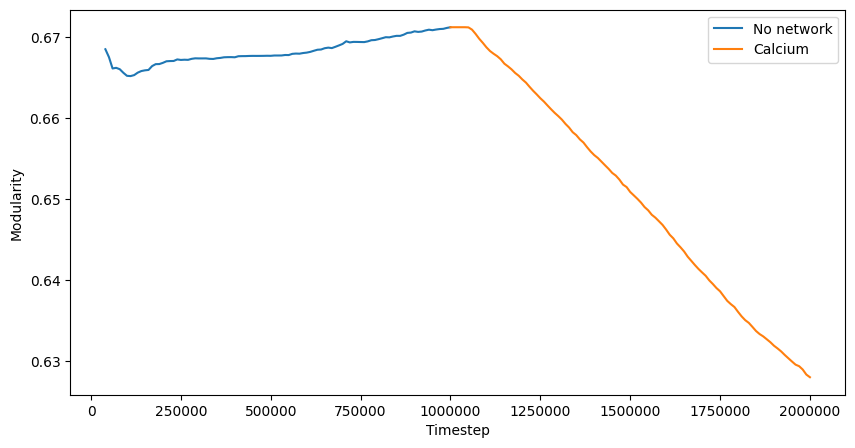

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(40000, 1_000_001, 10_000), df["no_network"].iloc[4:])
print(df)
ax.plot(range(1_000_000, 2_000_001, 10_000), df["calcium"])

ax.set_xlabel("Timestep")
ax.set_ylabel("Modularity")

ax.legend(["No network", "Calcium"])
ax.ticklabel_format(useOffset=False, style='plain')

plt.show()